In [1]:
%cd ..

/home/jairo/Documentos/GitHub/parallel-kink-scattering


/home/jairo/Documentos/GitHub/parallel-kink-scattering/.env/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from string import ascii_lowercase
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from multiprocessing import Pool, Value
from os import cpu_count

from modules.numeric import *

In [3]:
L = 40
N = 1000
DX = 2*L/(N - 1)
DT = 0.7*DX
LAMB = 2
X0 = 10

phi4 = Phi4(lamb=LAMB)

def y0(x, v):
    return np.stack((
        phi4.kink(x + X0, 0, v) - phi4.kink(x - X0, 0, v) - 1,
        phi4.kink_dt(x + X0, 0, v) - phi4.kink_dt(x - X0, 0, -v)
    ))

collider = Wave(
    x_grid= (-L, L, N), 
    dt= DT, 
    order= 4,
    y0= y0,
    F= phi4.diff,
    boundaries=[Reflective(4)]*2
)

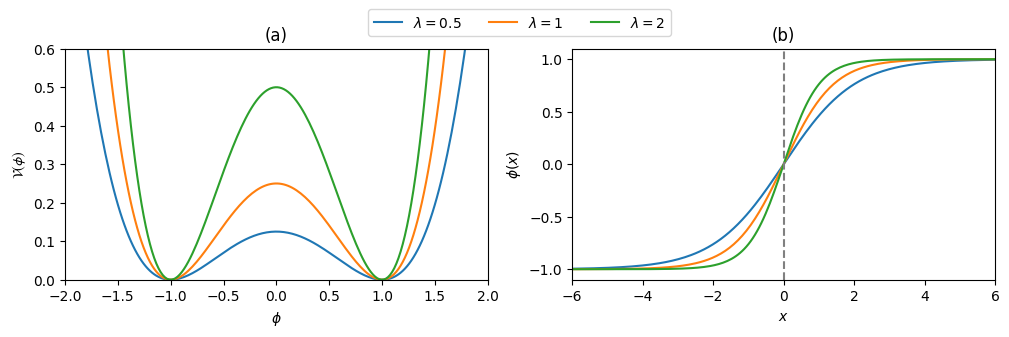

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

y = np.linspace(-2, 2, 200)
x = np.linspace(-6, 6, 200)
for lamb in (0.5, 1, 2):
    model = Phi4(lamb=lamb)
    ax1.plot(y, model(y))
    ax2.plot(x, model.kink(x, 0, 0), label=r'$\lambda=%s$'%lamb)
ax1.set_xlim(y.min(), y.max())
ax1.set_ylim(0, 0.6)
ax1.set_ylabel(r'$\mathcal{V(\phi)}$')
ax1.set_xlabel(r'$\phi$')
ax1.set_title('(a)')
ax2.set_xlim(x.min(), x.max())
# ax2.set_xticks([0], [r'$x_0$'])
ax2.axvline(0, ls='--', c='gray')
ax2.set_ylabel(r'$\phi(x)$')
ax2.set_xlabel(r'$x$')
ax2.legend(bbox_to_anchor=(0.25, 1.2), ncols=3)
ax2.set_title('(b)')
fig.savefig('reports/anninos/phi4-model.pdf', bbox_inches='tight', pad_inches=0)

(-25.0, 25.0)

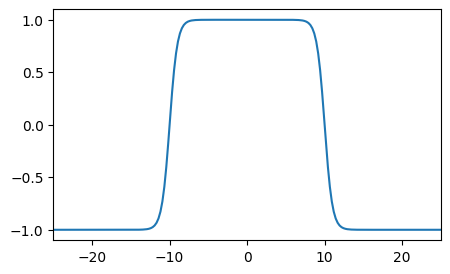

In [5]:
x = np.linspace(-25, 25, 200)
plt.figure(figsize=(5, 3))
plt.plot(x, y0(x, 0)[0])
plt.xlim(x.min(), x.max())

In [6]:
def run_and_plot(v, ax=None):
    lat, Y = collider.run(100, v=v)
    if ax == None: ax = plt.gca()
    im = ax.imshow(Y[:, 0].T, cmap='turbo', vmin=-1.2, vmax=1.2, extent=lat.extent(), aspect='auto', origin='lower')
    return im

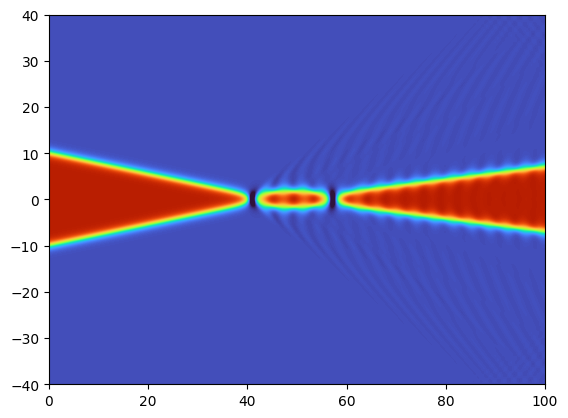

In [7]:
run_and_plot(0.225)
# plt.ylim(-20, 20)

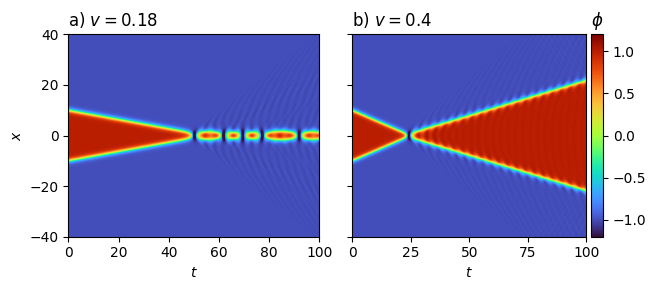

In [8]:
V = (0.18, 0.4)

w = 10/3
ncol = len(V)
fig, axs = plt.subplots(1, ncol, figsize=(w*ncol, 3), sharey=True)

for ax, v, alph in zip(axs, V, ascii_lowercase):
    im = run_and_plot(v, ax=ax)
    ax.set_xlabel(r'$t$')
    ax.set_title(r'%s) $v=%s$'%(alph, v), loc='left')

axs[0].set_ylabel(r'$x$')

divider = make_axes_locatable(axs[-1])
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(im, ax=axs[-1], cax=cax, location='right')
cax.set_title(r'$\phi$')

fig.tight_layout()
fig.savefig('reports/anninos/col1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

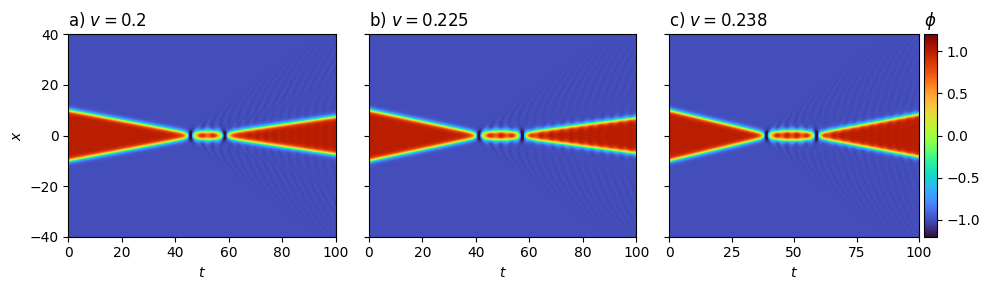

In [9]:
V = (0.2, 0.225, 0.238)

w = 10/3
ncol = len(V)
fig, axs = plt.subplots(1, ncol, figsize=(w*ncol, 3), sharey=True)

for ax, v, alph in zip(axs, V, ascii_lowercase):
    run_and_plot(v, ax=ax)
    ax.set_xlabel(r'$t$')
    ax.set_title(r'%s) $v=%s$'%(alph, v), loc='left')

axs[0].set_ylabel(r'$x$')

divider = make_axes_locatable(axs[-1])
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(im, ax=axs[-1], cax=cax, location='right')
cax.set_title(r'$\phi$')

fig.tight_layout()
fig.savefig('reports/anninos/col2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

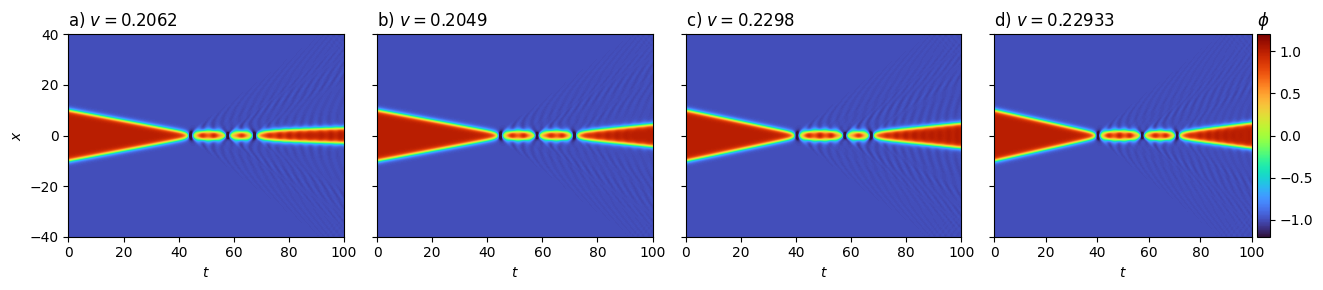

In [10]:
V = (0.2062, 0.2049, 0.2298, 0.22933)

w = 10/3
ncol = len(V)
fig, axs = plt.subplots(1, ncol, figsize=(w*ncol, 3), sharey=True)

for ax, v, alph in zip(axs, V, ascii_lowercase):
    run_and_plot(v, ax=ax)
    ax.set_xlabel(r'$t$')
    ax.set_title(r'%s) $v=%s$'%(alph, v), loc='left')

axs[0].set_ylabel(r'$x$')

divider = make_axes_locatable(axs[-1])
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(im, ax=axs[-1], cax=cax, location='right')
cax.set_title(r'$\phi$')

fig.tight_layout()
fig.savefig('reports/anninos/col3.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [18]:
CM = argnearest(collider.x, 0)

class BouncesCounter:
    def __init__(self):
        self.bounces = 0
        self._last_cm = None
        self.locs = []
        self._iter = 0

    def __call__(self, t, Y):
        y_cm = Y[0][CM]
        if self._last_cm != None and y_cm <= 0 and self._last_cm > 0:
            self.bounces += 1
            self.locs.append(self._iter)
        self._last_cm = y_cm
        self._iter += 1

def catch_cm(u):
    def _wrapped(t, Y):
        y, _ = Y
        u.append(y[CM])
    return _wrapped

def step_bisec(f, x1, x2, epsilon=1e-3):
    assert x1 < x2
    y1, y2 = f(x1), f(x2)
    assert y1 != y2
    while np.abs(x2-x1) > epsilon:
        xc = (x1 + x2)/2
        yc = f(xc)
        yield xc
        if y1 != yc: x2, y2 = xc, yc
        else: x1, y1 = xc, yc

def get_bounces(v):
    # COLLIDER.collide((v, -v), LAMB, X0/v + 300, callback=counter, **kw)
    counter = BouncesCounter()
    collider.run(X0/v + 300, v=v, stack=False, event=counter)
    return counter.bounces

def F(n):
    def checkout(v):
        return int(get_bounces(v) == n)
    return checkout

def progress(iterable, size=None):
    if size == None: size = len(iterable)
    for i, value in enumerate(iterable):
        print(f'\r{(i/size*100):.2f} %', end='')
        yield value
    print('\r')

def get_initial_ranges(a, b, Nk, n, rmax=None):
    v_in = a + (b - a)*np.log10(np.linspace(1, 10, Nk))
    initial_range = []
    bounces_counter = partial(get_bounces)
    bounces = np.fromiter(map(bounces_counter, v_in), np.float64)
    for slc in np.ma.clump_masked(np.ma.masked_equal(bounces, n)):
        v_slc = v_in[slc]
        if v_slc.ptp() > 0:
            initial_range.append((v_slc.min(), v_slc.max()))
        if rmax != None and len(initial_range) >= rmax:
            break
    return initial_range

def grind(initial_ranges, n=2, epsilon=1e-7):
    sim_amount = []
    ranges = []
    for vmin, vmax in initial_ranges:
        res = []
        sims = 0
        dv = (vmax - vmin)/2
        for v in (vmin, vmax):
            v1, v2 = v - dv, v + dv
            try:
                steps = tuple(step_bisec(F(n), v1, v2, epsilon=epsilon))
            except Exception as error: 
                print(error)
                sims += 0
                res.append(np.nan)
            else:
                sims += len(steps)
                res.append(steps[-1])
        ranges.append(res)
        sim_amount.append(sims)

    return ranges, sim_amount

# One-bounce

In [12]:
*_, v_c = step_bisec(F(1), 0.1, 0.3, epsilon=1e-5)
np.round(v_c, 4)

0.2599

# Two-bounce

In [13]:
initial_two_range = get_initial_ranges(0.18, v_c, Nk=150, n=2, rmax=5)
initial_two_range

[(0.19368038806049148, 0.20238423495744629),
 (0.224426022979126, 0.2287999810200378),
 (0.2374005743381218, 0.23934946216611633),
 (0.24428736515454552, 0.24525989783016133),
 (0.24831788914441819, 0.24889843174783122)]

In [14]:
two_bounces, sim_amount = grind(initial_two_range, n=2)
two_bounces

[[0.19258012225821758, 0.20345873558793662],
 [0.22405420717947516, 0.22887292926434194],
 [0.23714120239543734, 0.23966283771438607],
 [0.24398445779104044, 0.2454786345800175],
 [0.248048523612732, 0.24901344891645172]]

In [15]:
m = np.arange(5).astype(int) + 1
M = m + 2
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in two_bounces],
    'v2': [v2 for _, v2 in two_bounces]
})

df['dv'] = df.v2-df.v1
df['dv1'] = df.dv/df.dv[0]
df['beta'] = -np.log(df.dv1)/np.log(M/M[m == 1])

df

,m,v1,v2,dv,dv1,beta
0,1,0.192580,0.203459,0.010879,1.000000,NaN
1,2,0.224054,0.228873,0.004819,0.442954,2.830521
2,3,0.237141,0.239663,0.002522,0.231797,2.861820
3,4,0.243984,0.245479,0.001494,0.137350,2.864072
4,5,0.248049,0.249013,0.000965,0.088699,2.859093


In [16]:
print(df.to_latex(index=False))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dv1 & beta \\
\midrule
1 & 0.192580 & 0.203459 & 0.010879 & 1.000000 & NaN \\
2 & 0.224054 & 0.228873 & 0.004819 & 0.442954 & 2.830521 \\
3 & 0.237141 & 0.239663 & 0.002522 & 0.231797 & 2.861820 \\
4 & 0.243984 & 0.245479 & 0.001494 & 0.137350 & 2.864072 \\
5 & 0.248049 & 0.249013 & 0.000965 & 0.088699 & 2.859093 \\
\bottomrule
\end{tabular}



In [17]:
sim_amount, sum(sim_amount) + 2*len(sim_amount)

([34, 32, 30, 28, 26], 160)

# Three-bounce

## Mapping the region near first two-bounce window

In [55]:
dv = (two_bounces[1][0] - two_bounces[0][1])/6
VMIN, VMAX = two_bounces[0][1] - dv, two_bounces[1][0] + dv
v_in = np.linspace(VMIN, VMAX, 200)

counter = Value('i', 0)
total = len(v_in)
def task(v):
    counter.value += 1
    print(f'{(counter.value/total*100):.2f}%\r', end='')
    ycm = []
    collider.run(300, v=v, stack=False, event=catch_cm(ycm))
    return ycm

with Pool(int(cpu_count()*0.8)) as pool:
    Ycm = pool.map(task, v_in)

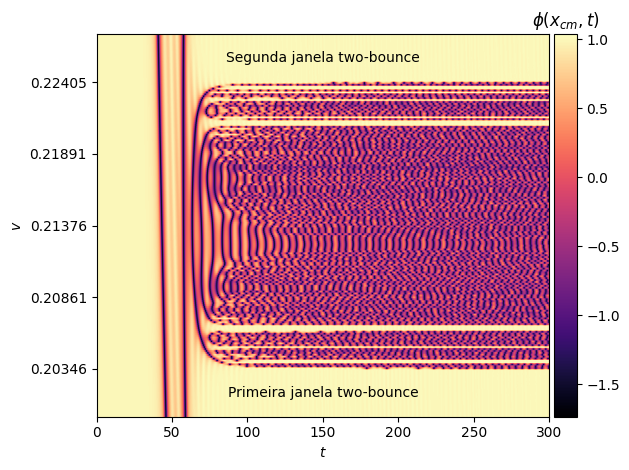

In [56]:
im = plt.imshow(Ycm, aspect='auto', extent=(0, 300, VMIN, VMAX), origin='lower', cmap='magma')

Vs = (two_bounces[0][1], two_bounces[1][0])
# for v in Vs:
#     plt.axhline(v, c='b', lw=1)
yticks = np.linspace(*Vs, 5)
plt.yticks(yticks)

plt.xlabel(r'$t$')
plt.ylabel(r'$v$')

# plt.title(r'$\phi(x=0, t)$')
plt.text(150, (VMIN + Vs[0])/2, r'Primeira janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.text(150, (VMAX + Vs[1])/2, r'Segunda janela two-bounce', horizontalalignment='center', verticalalignment='center')

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(im, ax=ax, cax=cax, location='right')
cax.set_title(r'$\phi(x_{cm},t)$')

plt.tight_layout()
plt.savefig('reports/anninos/three_mapping_1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [46]:
initial_three_range_1 = get_initial_ranges(*yticks[:2][::-1], Nk=250, n=3, rmax=5)
initial_three_range_1

[(0.20621473265680934, 0.20654255633823662),
 (0.20487789444365315, 0.20503580414521466),
 (0.20432667869207782, 0.20438706377225938),
 (0.20404703191719972, 0.20407880060346284),
 (0.20388482488183157, 0.20389462529890467)]

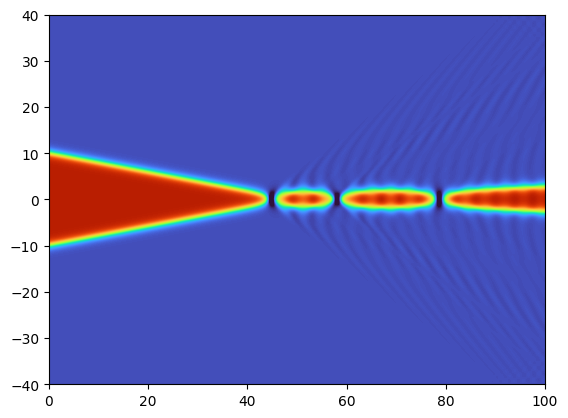

In [69]:
run_and_plot(0.20407880060346284)

In [47]:
three_bounces_1, sim_amount = grind(initial_three_range_1, n=3, epsilon=1e-8)
three_bounces_1

[[0.2061942186657581, 0.20655058485704597],
 [0.20486755282318347, 0.20503789560061253],
 [0.20432314787501155, 0.204399277893092],
 [0.20404004373694506, 0.2040806387818428],
 [nan, nan]]

In [48]:
m = np.arange(len(three_bounces_1)).astype(int) + 1
M = m + 1
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in three_bounces_1],
    'v2': [v2 for _, v2 in three_bounces_1]
})

df['dv'] = df.v2-df.v1
df['dvn'] = df.dv/df.dv[1]
df['beta'] = -np.log(df.dvn)/np.log(M/M[m == 2])

df.style.format('{:.7f}')

,m,v1,v2,dv,dvn,beta
0,1.0000000,0.2061942,0.2065506,0.0003564,2.0920534,1.8204922
1,2.0000000,0.2048676,0.2050379,0.0001703,1.0000000,nan
2,3.0000000,0.2043231,0.2043993,0.0000761,0.4469225,2.7995144
3,4.0000000,0.2040400,0.2040806,0.0000406,0.2383139,2.8075466
4,5.0000000,nan,nan,nan,nan,nan


In [49]:
print(df.to_latex(index=False, float_format='%.7f'))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dvn & beta \\
\midrule
1 & 0.2061942 & 0.2065506 & 0.0003564 & 2.0920534 & 1.8204922 \\
2 & 0.2048676 & 0.2050379 & 0.0001703 & 1.0000000 & NaN \\
3 & 0.2043231 & 0.2043993 & 0.0000761 & 0.4469225 & 2.7995144 \\
4 & 0.2040400 & 0.2040806 & 0.0000406 & 0.2383139 & 2.8075466 \\
5 & NaN & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



In [50]:
sim_amount

[32, 28, 26, 24, 0]

## Mapping the region outside second two-bounce window

In [57]:
dv = (two_bounces[2][0] - two_bounces[1][1])/6
VMIN, VMAX = two_bounces[1][1] - dv, two_bounces[2][0] + dv
v_in = np.linspace(VMIN, VMAX, 200)

counter = Value('i', 0)
total = len(v_in)
def task(v):
    counter.value += 1
    print(f'{(counter.value/total*100):.2f}%\r', end='')
    ycm = []
    collider.run(300, v=v, stack=False, event=catch_cm(ycm))
    return ycm

with Pool(int(cpu_count()*0.8)) as pool:
    Ycm = pool.map(task, v_in)

In [72]:
%%timeit
_ = collider.run(100, v=0.5)

370 ms ± 6.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


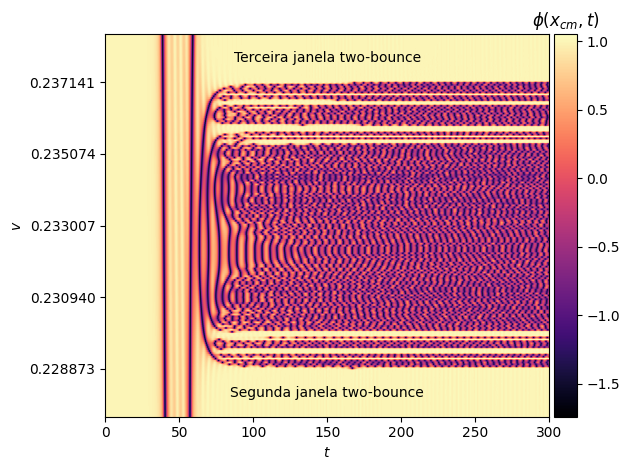

In [58]:
im = plt.imshow(Ycm, aspect='auto', extent=(0, 300, VMIN, VMAX), origin='lower', cmap='magma')

Vs = (two_bounces[1][1], two_bounces[2][0])
# for v in Vs:
#     plt.axhline(v, c='b', lw=1)
yticks = np.linspace(*Vs, 5)
plt.yticks(yticks)

plt.xlabel(r'$t$')
plt.ylabel(r'$v$')

# plt.title(r'$\phi(x=0, t)$')
plt.text(150, (VMIN + Vs[0])/2, r'Segunda janela two-bounce', horizontalalignment='center', verticalalignment='center')
plt.text(150, (VMAX + Vs[1])/2, r'Terceira janela two-bounce', horizontalalignment='center', verticalalignment='center')

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="5%", pad=0.05)
fig.colorbar(im, ax=ax, cax=cax, location='right')
cax.set_title(r'$\phi(x_{cm},t)$')

plt.tight_layout()
plt.savefig('reports/anninos/three_mapping_2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [59]:
%%time
initial_three_range_2 = get_initial_ranges(*yticks[:2][::-1], Nk=500, n=3, rmax=5)
initial_three_range_2

CPU times: user 10min 5s, sys: 73.7 ms, total: 10min 6s
Wall time: 10min 6s


[(0.22977295601562675, 0.2299058813515779),
 (0.22931870443282348, 0.22938207734892746),
 (0.22914289593621287, 0.22917178931529064),
 (0.22905543646181872, 0.22906943405514268),
 (0.22900340208843092, 0.22901281329534642)]

In [60]:
%%time
three_bounces_2, sim_amount = grind(initial_three_range_2, n=3, epsilon=1e-9)
three_bounces_2

CPU times: user 3min 32s, sys: 8.03 ms, total: 3min 32s
Wall time: 3min 32s


[[0.2297690145611729, 0.22990726108881823],
 [0.22931734580631094, 0.22938211312770393],
 [0.22914180167707482, 0.22917249736532114],
 [0.22905350649579587, 0.22907033880681077],
 [0.22900310396731344, 0.22901340551668004]]

In [64]:
m = np.arange(len(three_bounces_2)).astype(int) + 1
M = m + 1
df = pd.DataFrame({
    'm': m,
    'v1': [v1 for v1, _ in three_bounces_2],
    'v2': [v2 for _, v2 in three_bounces_2]
})

df['dv'] = df.v2-df.v1
df['dvn'] = df.dv/df.dv[1]
df['beta'] = -np.log(df.dvn)/np.log(M/M[m == 2])

df.style.format('{:.7f}')

,m,v1,v2,dv,dvn,beta
0,1.0000000,0.2297690,0.2299073,0.0001382,2.1345105,1.8700434
1,2.0000000,0.2293173,0.2293821,0.0000648,1.0000000,nan
2,3.0000000,0.2291418,0.2291725,0.0000307,0.4739379,2.5955006
3,4.0000000,0.2290535,0.2290703,0.0000168,0.2598889,2.6378882
4,5.0000000,0.2290031,0.2290134,0.0000103,0.1590547,2.6524047


In [65]:
print(df.to_latex(index=False, float_format='%.7f'))

\begin{tabular}{rrrrrr}
\toprule
m & v1 & v2 & dv & dvn & beta \\
\midrule
1 & 0.2297690 & 0.2299073 & 0.0001382 & 2.1345105 & 1.8700434 \\
2 & 0.2293173 & 0.2293821 & 0.0000648 & 1.0000000 & NaN \\
3 & 0.2291418 & 0.2291725 & 0.0000307 & 0.4739379 & 2.5955006 \\
4 & 0.2290535 & 0.2290703 & 0.0000168 & 0.2598889 & 2.6378882 \\
5 & 0.2290031 & 0.2290134 & 0.0000103 & 0.1590547 & 2.6524047 \\
\bottomrule
\end{tabular}



In [63]:
sim_amount

[36, 32, 30, 28, 28]

# Anninos plots

In [27]:
def plot_cm(v, t_lim=None, **kwargs):
    fig = plt.figure(figsize=(6, 4))
    lat, y, _ = COLLIDER.collide((v, -v), LAMB, X0/v + 300 if t_lim == None else t_lim)
    plt.plot(lat.t, y[:, CM], **kwargs)
    plt.xlim(0, t_lim)
    plt.ylim(-2, 1.5)
    plt.xlabel(r'$t$', fontsize=14)
    plt.ylabel(r'$\phi(x=0,t)$', fontsize=14)
    plt.title(r'$v=%s$'%v)
    fig.savefig(f'reports/anninos/y_cm - v={v}.png', format='png', pad_inches=0)

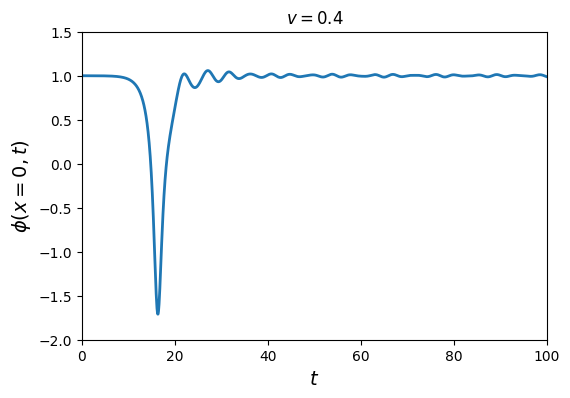

In [28]:
plot_cm(0.4, 100, c='tab:blue', lw=2)
plt.show()

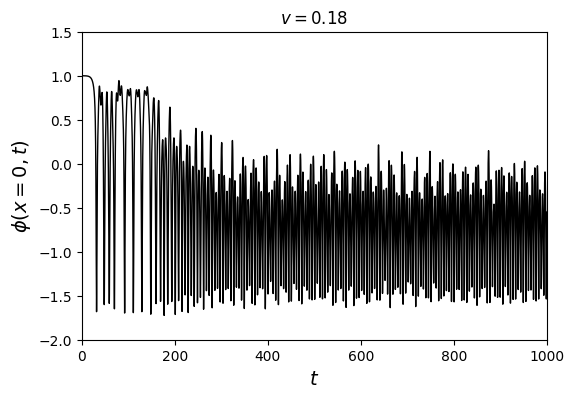

In [29]:
plot_cm(0.18, t_lim=1000, c='k', lw=1)
plt.show()

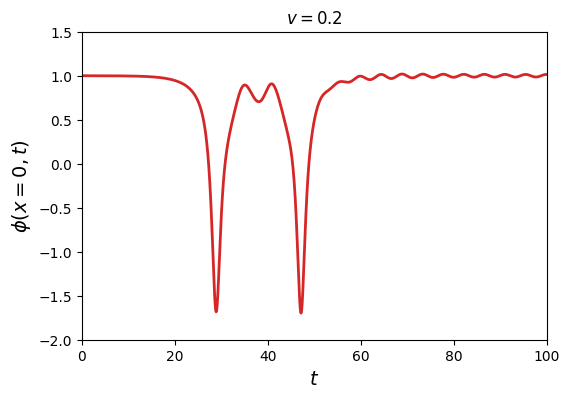

In [30]:
plot_cm(0.2, 100, c='tab:red', lw=2)
plt.show()

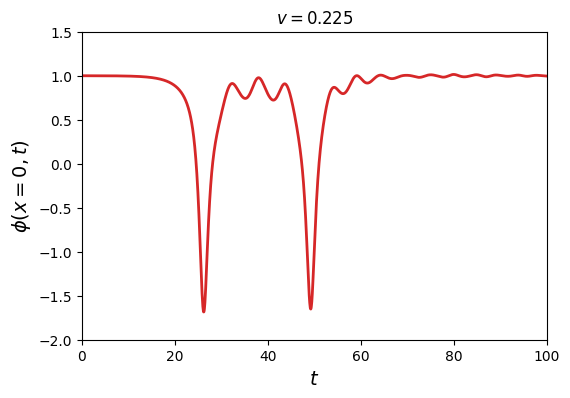

In [31]:
v = 0.225
plot_cm(0.225, 100, c='tab:red', lw=2)
plt.show()

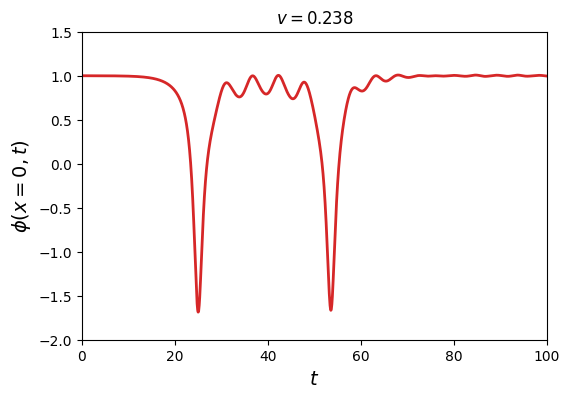

In [32]:
plot_cm(0.238, 100, c='tab:red', lw=2)
plt.show()

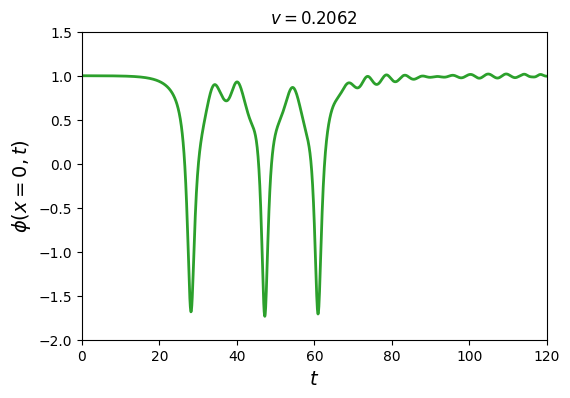

In [33]:
plot_cm(0.2062, 120, c='tab:green', lw=2)
plt.show()

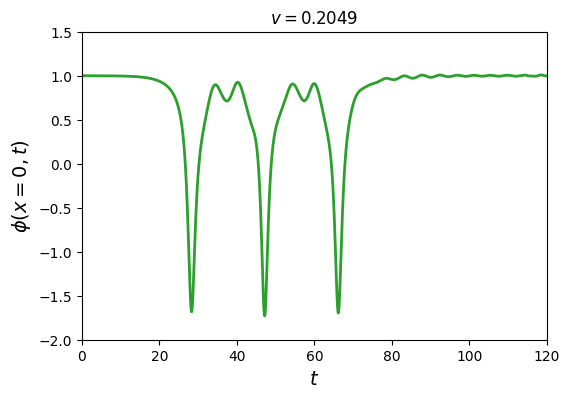

In [34]:
plot_cm(0.2049, 120, c='tab:green', lw=2)
plt.show()

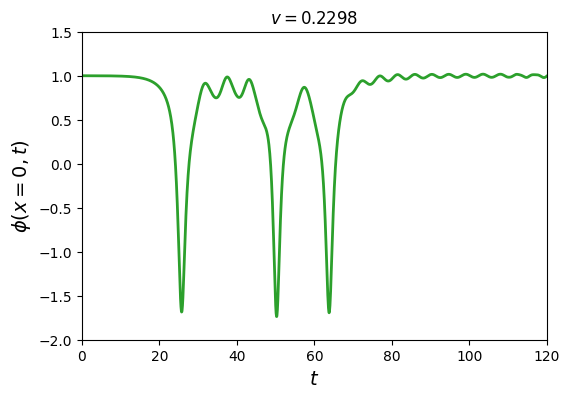

In [35]:
plot_cm(0.2298, 120, c='tab:green', lw=2)
plt.show()

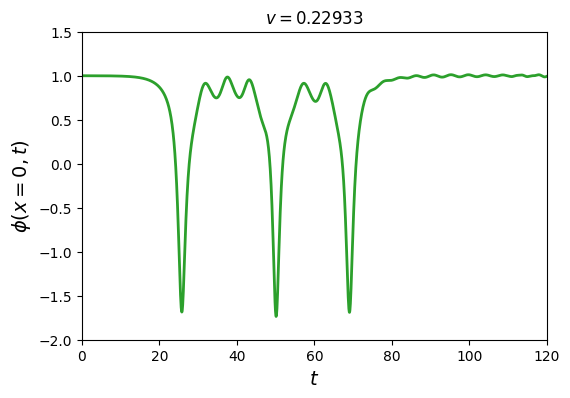

In [36]:
plot_cm(0.22933, 120, c='tab:green', lw=2)
plt.show()

# Resonance

In [13]:
def get_bounces_distance(vs, j=1, k=2, nmax=3):
    T = []
    for v in vs:
        counter = BouncesCounter(CM)
        COLLIDER.collide((v, -v), LAMB, X0/v + 300, callback=counter, stop_condition=counter.blocker(nmax))
        T.append((counter.locs[k-1] - counter.locs[j-1])*DT)
    return T

def linear(x, a, b):
    return a*x + b

def sig_digits(value, error):
    sig = 0
    l, r = str(error).split('.')
    if l == '0':
        for digit in r:
            sig += 1
            if digit != '0': break
    value = np.round(value, sig)
    error = np.round(error, sig)
    return (int(value), int(error)) if str(error).split('.')[-1] == '0' else (value, error)

In [10]:
%%time
initial_two_range = get_initial_ranges(0.18, v_c, Nk=1000, n=2, rmax=15)
initial_two_range

CPU times: user 7min 8s, sys: 26.5 s, total: 7min 34s
Wall time: 7min 35s


[(0.19266885930330846, 0.20338625519263703),
 (0.22406837411782202, 0.22880418096041216),
 (0.23717089064377264, 0.23960130326955725),
 (0.24400365295881027, 0.24544954179114475),
 (0.24804083700730634, 0.24899134345737972),
 (0.2506960332734336, 0.2512993237499523),
 (0.2524752773783755, 0.25293470653193023),
 (0.25379860654396735, 0.2540941145840199),
 (0.25478600730253975, 0.2550016601211384),
 (0.25553499195985324, 0.25571096038109636),
 (0.2561296737265612, 0.256268127887494),
 (0.256611861933542, 0.2567143206804618),
 (0.25701989146947923, 0.25708743166175907),
 (0.25732279089153626, 0.2573897437774291),
 (0.25762306524948886, 0.25765626899680055)]

In [11]:
%%time
two_bounces, sim_amount = grind(initial_two_range, n=2)
two_bounces



CPU times: user 4min 31s, sys: 18.3 s, total: 4min 50s
Wall time: 4min 50s


[[0.19255315865646244, 0.20344259282209065],
 [0.22403303766845026, 0.228860040010237],
 [0.23712497922362613, 0.23964736303031814],
 [0.24396561718691476, 0.24546127904790138],
 [0.24803114861758696, 0.2489977830457561],
 [0.25065825397479413, 0.25132134326319433],
 [0.2524649020862115, 0.25294093170722864],
 [0.25377097481072997, 0.25412564217520717],
 [0.2547526800969312, 0.25502519449855876],
 [0.2555120507643104, 0.2557265122777004],
 [0.2561118937244492, 0.2562840149616244],
 [0.25659430186510024, 0.2567342821257846],
 [0.25698856179044316, 0.25710398692373393],
 [0.2573157948380299, 0.25741217037885616],
 [nan, nan]]

In [12]:
sim_amount

[34, 32, 30, 28, 28, 26, 26, 24, 24, 22, 22, 22, 20, 20, 0]

In [17]:
T2 = get_bounces_distance((v1 for v1, _ in two_bounces[:-1]))
T2

[17.209209209209206,
 22.422422422422418,
 27.747747747747745,
 33.07307307307307,
 38.342342342342334,
 43.61161161161161,
 48.824824824824816,
 54.03803803803803,
 59.25125125125124,
 64.46446446446446,
 69.67767767767766,
 74.89089089089089,
 80.04804804804803,
 85.3173173173173]

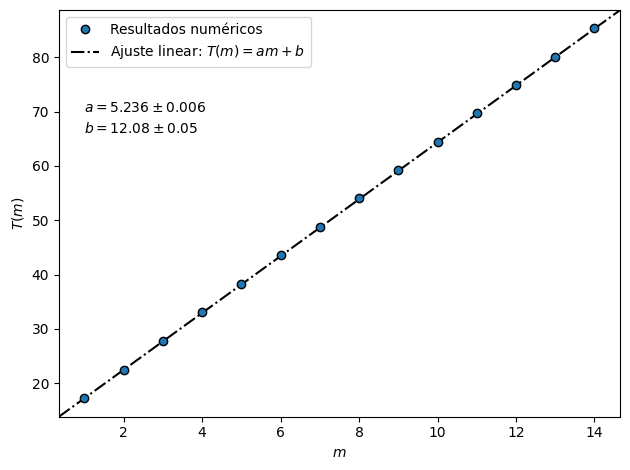

(5.236374836384076, 5.130199320647456, 2.069617749729461)

In [57]:
m = np.arange(len(T2)) + 1
plt.plot(m, T2, 'o', c='tab:blue', markeredgecolor='k', label='Resultados numéricos')

(a, b), pcov = curve_fit(linear, m, T2)
da, db = np.sqrt(np.diag(pcov))
plt.axline((m[0], T2[0]), slope=a, ls='-.', c='k', zorder=0, label=r'Ajuste linear: $T(m) = am + b$')
plt.text(1, 70, r'$a = %s \pm %s$'%sig_digits(a, da))
plt.text(1, 66, r'$b = %s \pm %s$'%sig_digits(b, db))

plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$T(m)$')

plt.tight_layout()
plt.savefig('reports/anninos/ressonance_2.png')
plt.show()

w1 = 3**0.5/delta(LAMB)
c = 2*np.pi/w1
a, c, abs(c-a)/c*100

In [41]:
%%time
initial_three_range = get_initial_ranges(0.230926, 0    , Nk=3000, n=3)
initial_three_range

CPU times: user 18min 58s, sys: 1min 1s, total: 20min
Wall time: 20min 1s


[(0.22975552217339146, 0.2298934420051886),
 (0.2293036998627449, 0.22936774391556847),
 (0.22912784956661436, 0.2291581148677405),
 (0.22903944080664634, 0.22905603725909668),
 (0.22898892705683252, 0.22899924500860086),
 (0.2289577653207437, 0.22896409310321675),
 (0.2289366959754317, 0.22894110621073852),
 (0.22892186127996414, 0.22892475077743274),
 (0.22891096527841148, 0.22891296251980414),
 (0.22890273802983555, 0.22890415114966506),
 (0.22889626619151762, 0.22889738838060172),
 (0.22889123363708078, 0.22889207043839838),
 (0.2288870612969599, 0.22888761648924963),
 (0.2288837373381912, 0.2288842904768892),
 (0.228880701155725, 0.22888125242526458),
 (0.2288784994583224, 0.22887877437522572),
 (0.22887465944015348, 0.22887493318281552)]

In [58]:
%%time
three_bounces, sim_amount = grind(initial_three_range, n=3, epsilon=1e-8)
three_bounces



CPU times: user 3min 29s, sys: 8.68 s, total: 3min 38s
Wall time: 3min 38s


[[0.22975505918567485, 0.2298937029619016],
 [0.2293032698794801, 0.22936818953458835],
 [0.22912766484187602, 0.22915844737226942],
 [0.22903933545807123, 0.22905622364503728],
 [0.22898892201877014, 0.22899925004666324],
 [0.22895752432121588, 0.2289642723079938],
 [0.2289365495418375, 0.2289411492794427],
 [0.22892169761702158, 0.22892498216297225],
 [0.22891075463185834, 0.22891318876980565],
 [0.2289024565098695, 0.22890434434964174],
 [0.22889604701396216, 0.22889753742133945],
 [0.22889099174919988, 0.22889216850105276],
 [0.22888691382400794, 0.22888785071099688],
 [0.2288835212683873, 0.2288843164052657],
 [0.22888069254213844, 0.22888136440188983],
 [nan, nan],
 [0.2288746337767789, 0.22887504439077194]]

In [59]:
sim_amount

[28, 26, 24, 22, 22, 20, 18, 18, 16, 16, 14, 14, 12, 12, 12, 0, 10]

In [60]:
T3 = get_bounces_distance((v1 for v1, _ in three_bounces if not np.isnan(v1)), 2, 3)[:-2]
T3, len(T3)

([13.62162162162162,
  19.339339339339336,
  24.776776776776774,
  30.158158158158155,
  35.48348348348348,
  40.808808808808806,
  46.022022022022014,
  51.29129129129129,
  56.504504504504496,
  61.71771771771771,
  66.93093093093093,
  72.14414414414414,
  77.3013013013013,
  82.5145145145145],
 14)

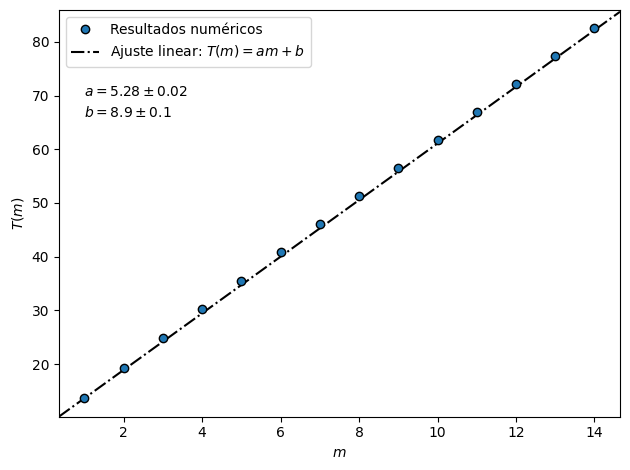

(5.275675675685001, 5.130199320647456, 2.8356862169477033)

In [61]:
m = np.arange(len(T3)) + 1
plt.plot(m, T3, 'o', c='tab:blue', markeredgecolor='k', label='Resultados numéricos')

(a, b), pcov = curve_fit(linear, m, T3)
da, db = np.sqrt(np.diag(pcov))
plt.axline((m[0], T3[0]), slope=a, ls='-.', c='k', zorder=0, label=r'Ajuste linear: $T(m) = am + b$')
plt.text(1, 70, r'$a = %s \pm %s$'%sig_digits(a, da))
plt.text(1, 66, r'$b = %s \pm %s$'%sig_digits(b, db))

plt.legend()
plt.xlabel(r'$m$')
plt.ylabel(r'$T(m)$')

plt.tight_layout()
plt.savefig('reports/anninos/ressonance_3.png')
plt.show()

w1 = 3**0.5/delta(LAMB)
c = 2*np.pi/w1
a, c, abs(c-a)/c*100